# 21点游戏的蒙特卡洛学习评估玩家策略

## 示例：二十一点游戏 Blackjack Example
本章的编程实践将使用MC学习来评估二十一点游戏中一个玩家的策略。为了完成这个任务，我们需要先了解二十一点游戏的规则，并构建一个游戏场景让庄家和玩家在一个给定的策略下进行博弈生成对局数据。这里的对局数据在强化学习看来就是一个个完整的状态序列组成的集合。然后我们使用本章介绍的蒙特卡罗算法来评估其中玩家的策略。本节的难点不在于蒙特卡罗学习算法的实现，而是对游戏场景的实现并生成让蒙特卡罗学算法学习的多个状态序列。

**二十一点游戏规则**

二十一点游戏是一个比较经典的对弈游戏，其规则也有各种不同的版本，为了简化，本文仅介绍由一个庄家(dealer)和一个玩家(player)共2位游戏者参与的一个比较基本的规则版本。游戏使用一副除大小王以外的52张扑克牌，游戏者的目标是使手中的牌的点数之和不超过21点且尽量大。其中2-10的数字牌点数就是牌面的数字，J,Q,K三类牌均记为10点，A既可以记为1也可以记为11，由游戏者根据目标自己决定。牌的花色对于计算点数没有影响。

开局时，庄家将依次连续发2张牌给玩家和庄家，其中庄家的第一张牌是明牌，其牌面信息对玩家是开放的，庄家的第二张牌信息不对玩家开放。随后玩家可以根据自己手中牌的点数决定是否继续要牌(twist)或停止要牌(stick),玩家可以连续继续要牌，但一旦手中牌点数超过21点则不应继续要牌。当玩家停止要牌后，庄家可以决定是否继续要牌。如果庄家停止要牌，对局结束，双方亮牌计算输赢。

计算输赢的规则如下：如果双方点数均超过21点或双方点数相同，则和局；一方21点另一方不是21点，则点数为21点的游戏者赢；如果双方点数均不到21点，则点数离21点近的玩家赢。

**将二十一点游戏建模为强化学习问题**

为了讲解基于完整状态序列的蒙特卡洛学习算法，我们把二十一点游戏建模成强化学习问题，设定由下面三个参数来集体描述一个状态：庄家的明牌(第一张牌)点数；玩家手中所有牌点数之和；玩家手中是否还有“可用(useable)”的A(ace)。前两个比较好理解，第三个参数是与玩家策略相关的，玩家是否有A这个比较好理解，可用的A指的是玩家手中的A按照目标最大化原则是否没有被计作1点，如果这个A没有被记为1点而是计为了11点，则成这个A为可用的A，否则认为没有可用的A，当然如果玩家手中没有A，那么也被认为是没有可用的A。例如玩家手中的牌为“A,3,6”，那么此时根据目标最大化原则，A将被计为11点，总点数为20点，此时玩家手中的A称为可用的A。加入玩家手中的牌为“A，5,7”，那么此时的A不能被计为11点只能按1计，相应总点数被计为13点，否则总点数将为23点，这时的A就不能称为可用的A。
根据我们对状态的设定，我们使用由三个元素组成的元组来描述一个状态。例如使用(10,15, 0)表示的状态是庄家的明牌是10，玩家手中的牌加起来点数是15，并且玩家手中没有可用的A，(A,17,1)表述的状态是庄家第一张牌为A，玩家手中牌总点数为17,玩家手中有可用的A。这样的状态设定不考虑玩家手中的具体牌面信息，也不记录庄家除第一张牌外的其它牌信息。所有可能的状态构成了状态空间。

该问题的行为空间比较简单，玩家只有两种选择：“继续要牌”或“停止要牌”。

该问题中的状态如何转换取决于游戏者的行为以及后续发给游戏者的牌，状态间的转移概率很难计算。

可以设定奖励如下：当棋局未结束时，任何状态对应的奖励为0；当棋局结束时，如果玩家赢得对局，奖励值为1，玩家输掉对局，奖励值为-1，和局是奖励为0。

本问题中衰减因子$\gamma=1$。

游戏者在选择行为时都会遵循一个策略。在本例中，庄家遵循的策略是只要其手中的牌点数达到或超过17点就停止要牌。我们设定玩家遵循的策略是只要手中的牌点数不到20点就会继续要牌，点数达到或超过20点就停止要牌。

我们的任务是评估玩家的这个策略，即计算在该策略下的状态价值函数，也就是计算状态空间中的每一个状态其对应的价值。

**游戏场景的搭建**

首先来搭建这个游戏场景，实现生成对局数据的功能，我们要实现的功能包括：统计游戏者手中牌的总点数、判断当前牌局信息对应的奖励、实现庄家与玩家的策略、模拟对局的过程生成对局数据等。为了能尽可能生成较符合实际的对局数据，我们将循环使用一副牌，对局过程中发牌、洗牌、收集已使用牌等过程都将得到较为真实的模拟。

先讲解如何判断游戏者手中牌的总点数。由于不涉及牌的花色，我们使用长度为1的字符串来记录单张牌的牌面信息。为了判断游戏者手中多张牌的总点数，我们编写了如下两个方法：

## 1. 蒙特卡罗预测

In [1]:
from random import shuffle
from queue import Queue
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from utils import str_key, set_dict, get_dict

In [2]:
class Gamer():
    '''游戏者
    '''
    def __init__(self, name = "", A = None, display = False):
        self.name = name
        self.cards = [] # 手中的牌
        self.display = display # 是否显示对局文字信息
        self.policy = None # 策略
        self.learning_method = None # 学习方法
        self.A = A # 行为空间
        
    def __str__(self):
        return self.name
    
    def _value_of(self, card):
        '''根据牌的字符判断牌的数值大小，A被输出为1, JQK均为10，其余按牌字符对应的数字取值
        Args:
            card: 牌面信息 str
        Return:
            牌的大小数值 int, A 返回 1
        '''
        try:
            v = int(card)
        except:
            if card == 'A':
                v = 1
            elif card in ['J','Q','K']:
                v = 10
            else:
                v = 0
        finally:
            return v
    
    def get_points(self):
        '''统计一手牌分值，如果使用了A的1点，同时返回True
        Args:
            cards 庄家或玩家手中的牌 list ['A','10','3']
        Return
            tuple (返回牌总点数,是否使用了可复用Ace) 
            例如['A','10','3'] 返回 (14, False)
               ['A','10'] 返回 （21, True)
        '''
        num_of_useable_ace = 0 # 默认没有拿到Ace
        total_point = 0 # 总值
        cards = self.cards
        if cards is None:
            return 0, False
        for card in cards:
            v = self._value_of(card)
            if v == 1:
                num_of_useable_ace += 1
                v = 11
            total_point += v
        while total_point > 21 and num_of_useable_ace > 0:
            total_point -= 10
            num_of_useable_ace -= 1
        return total_point, bool(num_of_useable_ace)
    
    def receive(self, cards = []): # 玩家获得一张或多张牌
        cards = list(cards)
        for card in cards:
            self.cards.append(card)
    
    def discharge_cards(self): # 玩家把手中的牌清空，扔牌
        '''扔牌
        '''
        self.cards.clear()
    
    
    def cards_info(self): # 玩家手中牌的信息
        '''
        显示牌面具体信息
        '''
        self._info("{}{}现在的牌:{}\n".format(self.role, self,self.cards))
    
    def _info(self, msg):
        if self.display:
            print(msg, end="")
        
        
class Dealer(Gamer):
    def __init__(self, name = "", A = None, display = False):
        super(Dealer,self).__init__(name, A, display)
        self.role = "庄家"
        self.policy = self.dealer_policy
    
    def first_card_value(self):
        if self.cards is None or len(self.cards) == 0:
            return 0
        return self._value_of(self.cards[0])
    
    def dealer_policy(self, Dealer = None):
        action = ""
        dealer_points, _ = self.get_points()
        if dealer_points >= 17:
            action = self.A[1] # "停止要牌"
        else:
            action = self.A[0]
        return action
        

class Player(Gamer):
    def __init__(self, name = "", A = None, display = False):
        super(Player, self).__init__(name, A, display)
        self.policy = self.naive_policy
        self.role = "玩家" # “庄家”还是“玩家”，庄家是特殊的玩家
    
    def get_state(self, dealer):
        dealer_first_card_value = dealer.first_card_value()
        player_points, useable_ace = self.get_points()
        return dealer_first_card_value, player_points, useable_ace
        
    def get_state_name(self, dealer):
        return str_key(self.get_state(dealer))

    def naive_policy(self, dealer=None):
        player_points, _ = self.get_points()
        if player_points < 20:
            action = self.A[0]
        else:
            action = self.A[1]        
        return action  
        

In [3]:
class Arena():
    '''负责游戏管理
    '''
    def __init__(self, display = None, A = None):
        self.cards = ['A','2','3','4','5','6','7','8','9','10','J','Q',"K"]*4
        self.card_q = Queue(maxsize = 52) # 洗好的牌
        self.cards_in_pool = [] # 已经用过的公开的牌  
        self.display = display
        self.episodes = [] # 产生的对局信息列表
        self.load_cards(self.cards)# 把初始状态的52张牌装入发牌器
        self.A = A # 获得行为空间

    def load_cards(self, cards):
        '''把收集的牌洗一洗，重新装到发牌器中
        Args:
            cards 要装入发牌器的多张牌 list
        Return:
            None
        '''
        shuffle(cards) # 洗牌
        for card in cards:# deque数据结构只能一个一个添加
            self.card_q.put(card)
        cards.clear() # 原来的牌清空
        return
       
    def reward_of(self, dealer, player):
        '''判断玩家奖励值，附带玩家、庄家的牌点信息
        '''
        dealer_points, _ = dealer.get_points()
        player_points, useable_ace = player.get_points()
        if player_points > 21:
            reward = -1
        else:
            if player_points > dealer_points or dealer_points > 21:
                reward = 1
            elif player_points == dealer_points:
                reward = 0
            else:
                reward = -1
        return reward, player_points, dealer_points, useable_ace
    
    def serve_card_to(self, player, n = 1):
        '''给庄家或玩家发牌，如果牌不够则将公开牌池的牌洗一洗重新发牌
        Args:
            player 一个庄家或玩家 
            n 一次连续发牌的数量
        Return:
            None
        '''
        cards = []  #将要发出的牌
        for _ in range(n):
            # 要考虑发牌器没有牌的情况
            if self.card_q.empty():
                self._info("\n发牌器没牌了，整理废牌，重新洗牌;")
                shuffle(self.cards_in_pool)
                self._info("一共整理了{}张已用牌，重新放入发牌器\n".format(len(self.cards_in_pool)))
                assert(len(self.cards_in_pool) > 20) # 确保有足够的牌，将该数值设置成40左右时，如果玩家
                # 即使爆点了也持续的叫牌，会导致玩家手中牌变多而发牌器和已使用的牌都很少，需避免这种情况。
                self.load_cards(self.cards_in_pool) # 将收集来的用过的牌洗好送入发牌器重新使用
            cards.append(self.card_q.get()) # 从发牌器发出一章牌
        self._info("发了{}张牌({})给{}{};".format(n, cards, player.role, player))
        #self._info(msg)
        player.receive(cards) # 牌已发给某一玩家
        player.cards_info()

        
    def _info(self, message):
        if self.display:
            print(message, end="")
        
    def recycle_cards(self, *players):
        '''回收玩家手中的牌到公开使用过的牌池中
        '''
        if len(players) == 0:
            return
        for player in players:
            for card in player.cards:
                self.cards_in_pool.append(card)
            player.discharge_cards() # 玩家手中不再留有这些牌
                
    def play_game(self, dealer, player):
        '''玩一局21点，生成一个状态序列以及最终奖励（中间奖励为0）
        Args：
            dealer/player 庄家和玩家手中的牌 list
        Returns:
            tuple：episode, reward
        '''
        #self.collect_player_cards()
        self._info("========= 开始新一局 =========\n")
        self.serve_card_to(player, n=2) # 发两张牌给玩家
        self.serve_card_to(dealer, n=2) # 发两张牌给庄家
        episode = [] # 记录一个对局信息
        if player.policy is None:
            self._info("玩家需要一个策略")
            return
        if dealer.policy is None:
            self._info("庄家需要一个策略")
            return
        while True:
            action = player.policy(dealer)
            # 玩家的策略产生一个行为
            self._info("{}{}选择:{};".format(player.role, player, action))
            episode.append((player.get_state_name(dealer), action)) # 记录一个(s,a)
            if action == self.A[0]: # 继续叫牌
                self.serve_card_to(player) # 发一张牌给玩家
            else: # 停止叫牌
                break
        # 玩家停止叫牌后要计算下玩家手中的点数，玩家如果爆了，庄家就不用继续了        
        reward, player_points, dealer_points, useable_ace = self.reward_of(dealer, player)
        
        if player_points > 21:
            self._info("玩家爆点{}输了，得分:{}\n".format(player_points, reward))
            self.recycle_cards(player, dealer)
            self.episodes.append((episode, reward)) # 预测的时候需要形成episode list后同一学习V
            # 在蒙特卡洛控制的时候，可以不需要episodes list,生成一个episode学习一个，下同
            self._info("========= 本局结束 ==========\n")
            return episode, reward
        # 玩家并没有超过21点
        self._info("\n")
        while True:
            action = dealer.policy() # 庄家从其策略中获取一个行为
            self._info("{}{}选择:{};".format(dealer.role, dealer, action))
            if action == self.A[0]: # 庄家"继续要牌":
                self.serve_card_to(dealer)
                # 停止要牌是针对玩家来说的，episode不记录庄家动作
                # 在状态只记录庄家第一章牌信息时，可不重复记录(s,a)，因为此时玩家不再叫牌，(s,a)均相同
                # episode.append((get_state_name(dealer, player), self.A[1]))
            else:
                break
        # 双方均停止叫牌了    
        self._info("\n双方均了停止叫牌;\n")
        reward, player_points, dealer_points, useable_ace = self.reward_of(dealer, player)
        player.cards_info() 
        dealer.cards_info()
        if reward == +1:
            self._info("玩家赢了!")
        elif reward == -1:
            self._info("玩家输了!")
        else:
            self._info("双方和局!")
        self._info("玩家{}点,庄家{}点\n".format(player_points, dealer_points))
        
        self._info("========= 本局结束 ==========\n")
        self.recycle_cards(player, dealer) # 回收玩家和庄家手中的牌至公开牌池
        self.episodes.append((episode, reward)) # 将刚才产生的完整对局添加值状态序列列表，蒙特卡洛控制不需要
        return episode, reward
    
    def play_games(self, dealer, player, num=2, show_statistic = True):
        '''一次性玩多局游戏
        '''
        results = [0, 0, 0]# 玩家负、和、胜局数
        self.episodes.clear()
        for i in tqdm(range(num)):
            episode, reward = self.play_game(dealer, player)
            results[1+reward] += 1
            if player.learning_method is not None:
                player.learning_method(episode ,reward)
        if show_statistic:
            print("共玩了{}局，玩家赢{}局，和{}局，输{}局，胜率：{:.2f},不输率:{:.2f}"\
              .format(num, results[2],results[1],results[0],results[2]/num,(results[2]+results[1])/num))
        pass
    


In [4]:
A=["继续叫牌","停止叫牌"]
display = False
# 创建一个玩家一个庄家，玩家使用原始策略，庄家使用其固定的策略
player = Player(A = A, display = display)
dealer = Dealer(A = A, display = display)
# 创建一个场景
arena = Arena(A = A, display=display)
# 生成num个完整的对局

In [5]:
arena.play_games(dealer, player, num=200000)

100%|██████████| 200000/200000 [00:19<00:00, 10142.90it/s]

共玩了200000局，玩家赢58785局，和11180局，输130035局，胜率：0.29,不输率:0.35


In [6]:
# 统计个状态的价值，衰减因子为1，中间状态的即时奖励为0，递增式蒙特卡洛评估
def policy_evaluate(episodes, V, Ns):
    for episode, r in episodes:
        for s, a in episode:
            ns = get_dict(Ns, s)
            v = get_dict(V, s)
            set_dict(Ns, ns+1, s)
            set_dict(V, v+(r-v)/(ns+1), s)
        

In [7]:
V = {} # 状态价值字典
Ns = {} # 状态被访问的次数节点
policy_evaluate(arena.episodes, V, Ns) # 学习V值
#print(V)

In [8]:
def draw_value(value_dict, useable_ace = True, is_q_dict = False, A = None):
    # 定义figure
    fig = plt.figure()
    # 将figure变为3d
    ax = Axes3D(fig)
    # 定义x, y
    x = np.arange(1, 11, 1) # 庄家第一张牌
    y = np.arange(12, 22, 1) # 玩家总分数
    # 生成网格数据
    X, Y = np.meshgrid(x, y)
    # 从V字典检索Z轴的高度
    row, col = X.shape
    Z = np.zeros((row,col))
    if is_q_dict:
        n = len(A)
    for i in range(row):
        for j in range(col):
            state_name = str(X[i,j])+"_"+str(Y[i,j])+"_"+str(useable_ace)
            if not is_q_dict:
                Z[i,j] = get_dict(value_dict, state_name)
            else:
                assert(A is not None)
                for a in A:
                    new_state_name = state_name + "_" + str(a)
                    q = get_dict(value_dict, new_state_name)
                    if q >= Z[i,j]:
                        Z[i,j] = q
    # 绘制3D曲面
    ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, color="lightgray")
    plt.show()

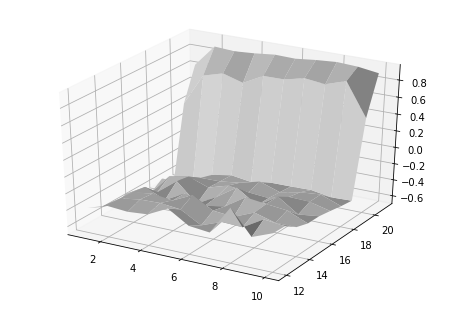

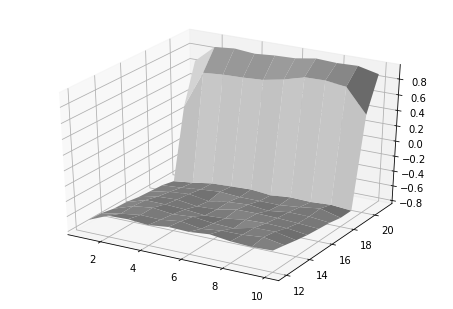

In [9]:
draw_value(V, useable_ace = True, A = A) # 绘制状态价值图
draw_value(V, useable_ace = False, A = A) # 绘制状态价值图

In [10]:
# 观察几局对局信息
display = True
player.display, dealer.display, arena.display = display, display, display
arena.play_games(dealer, player, num =2)

100%|██████████| 2/2 [00:00<00:00, 885.90it/s]

========= 开始新一局 =========
发了2张牌(['Q', 'Q'])给玩家;玩家现在的牌:['Q', 'Q']
发了2张牌(['K', '2'])给庄家;庄家现在的牌:['K', '2']
玩家选择:停止叫牌;
庄家选择:继续叫牌;发了1张牌(['4'])给庄家;庄家现在的牌:['K', '2', '4']
庄家选择:继续叫牌;发了1张牌(['10'])给庄家;庄家现在的牌:['K', '2', '4', '10']
庄家选择:停止叫牌;
双方均了停止叫牌;
玩家现在的牌:['Q', 'Q']
庄家现在的牌:['K', '2', '4', '10']
玩家赢了!玩家20点,庄家26点
========= 本局结束 ==========
========= 开始新一局 =========
发了2张牌(['9', '4'])给玩家;玩家现在的牌:['9', '4']
发了2张牌(['J', 'A'])给庄家;庄家现在的牌:['J', 'A']
玩家选择:继续叫牌;发了1张牌(['5'])给玩家;玩家现在的牌:['9', '4', '5']
玩家选择:继续叫牌;发了1张牌(['4'])给玩家;玩家现在的牌:['9', '4', '5', '4']
玩家选择:停止叫牌;玩家爆点22输了，得分:-1
========= 本局结束 ==========
共玩了2局，玩家赢1局，和0局，输1局，胜率：0.50,不输率:0.50


## 2. 蒙特卡洛控制

In [11]:
from utils import epsilon_greedy_policy

In [12]:
class MC_Player(Player):
    def __init__(self, name = "", A = None, display = False):
        super(MC_Player, self).__init__(name, A, display)
        self.Q = {}   # 某一状态行为对的价值，策略迭代时使用
        self.Nsa = {} # Nsa的计数：某一状态行为对出现的次数
        self.total_learning_times = 0
        self.policy = self.greedy_policy
        self.learning_method = self.learn_Q
    
    def learn_Q(self, episode, r): # 从状态序列来学习Q值
        '''从Episode学习
        '''
        #for episode, r in episodes:
        for s, a in episode:
            nsa = get_dict(self.Nsa, s, a)
            set_dict(self.Nsa, nsa+1, s, a)
            q = get_dict(self.Q, s,a)
            set_dict(self.Q, q+(r-q)/(nsa+1), s, a)
        self.total_learning_times += 1
    
    def reset_memory(self):
        '''忘记既往学习经历
        '''
        self.Q.clear()
        self.Nsa.clear()
        self.total_learning_times = 0

    
    def greedy_policy(self, dealer, epsilon = None):
        player_points, _ = self.get_points()
        if player_points >= 21:
            return self.A[1]
        if player_points < 12:
            return self.A[0]
        else:
            A, Q = self.A, self.Q
            s = self.get_state_name(dealer)
            if epsilon is None:
                #epsilon = 1.0/(self.total_learning_times+1)
                #epsilon = 1.0/(1 + math.sqrt(1 + player.total_learning_times))
                epsilon = 1.0/(1 + 4 * math.log10(1+player.total_learning_times))
            return epsilon_greedy_policy(A, s, Q, epsilon)


In [13]:
display = False
player = MC_Player(A = A, display = display)
dealer = Dealer(A = A, display = display)
# 创建一个场景
arena = Arena(A = A, display=display)

In [14]:
arena.play_games(dealer = dealer, player = player,num = 2000000, show_statistic = True)
#print(player.Q)
#print(player.A)

100%|██████████| 2000000/2000000 [04:11<00:00, 7951.43it/s]

共玩了2000000局，玩家赢853503局，和179007局，输967490局，胜率：0.43,不输率:0.52


In [59]:
def draw_policy(policy, A, Q, epsilon, useable_ace = False):
    def value_of(a):
        if a == A[0]:
            return 0
        else:
            return 1
    rows, cols = 11, 10
    useable_ace = bool(useable_ace)
    Z = np.zeros((rows, cols))
    dealer_first_card = np.arange(1, 12) # 庄家第一张牌
    player_points = np.arange(12,22)
    for i in range(11, 22): # 玩家总牌点
        for j in range(1, 11): # 庄家第一张牌 
            s = j, i, useable_ace
            s = str_key(s)
            a = policy(A, s, Q, epsilon)
            Z[i-11,j-1] = value_of(a)
            #print(s, a)
    
    plt.imshow(Z, cmap=plt.cm.cool, interpolation=None, origin="lower", extent=[0.5,11.5,10.5,21.5])

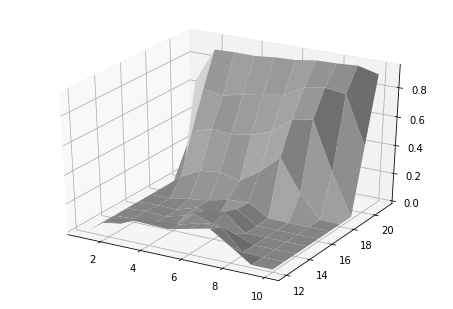

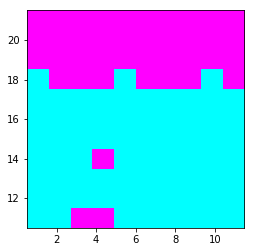

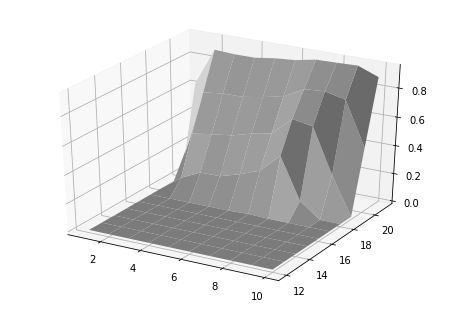

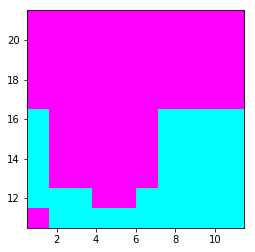

In [60]:
draw_value(player.Q, useable_ace = True, is_q_dict=True, A = player.A)
draw_policy(epsilon_greedy_policy, player.A, player.Q, epsilon = 1e-10, useable_ace = True)
draw_value(player.Q, useable_ace = False, is_q_dict=True, A = player.A)
draw_policy(epsilon_greedy_policy, player.A, player.Q, epsilon = 1e-10, useable_ace = False)

In [19]:
display = False
arena.display = display
player.display = display
dealer.display = display
arena.play_games(dealer,player,num=10000, show_statistic = True)

100%|██████████| 10000/10000 [00:01<00:00, 7908.94it/s]

共玩了10000局，玩家赢4411局，和915局，输4674局，胜率：0.44,不输率:0.53


In [20]:
display = True
arena.display = display
player.display = display
dealer.display = display
arena.play_games(dealer,player,num=10, show_statistic = True)

100%|██████████| 10/10 [00:00<00:00, 1836.39it/s]

========= 开始新一局 =========
发了2张牌(['A', '7'])给玩家;玩家现在的牌:['A', '7']
发了2张牌(['5', '3'])给庄家;庄家现在的牌:['5', '3']
玩家选择:继续叫牌;发了1张牌(['2'])给玩家;玩家现在的牌:['A', '7', '2']
玩家选择:停止叫牌;
庄家选择:继续叫牌;发了1张牌(['9'])给庄家;庄家现在的牌:['5', '3', '9']
庄家选择:停止叫牌;
双方均了停止叫牌;
玩家现在的牌:['A', '7', '2']
庄家现在的牌:['5', '3', '9']
玩家赢了!玩家20点,庄家17点
========= 本局结束 ==========
========= 开始新一局 =========
发了2张牌(['4', '8'])给玩家;玩家现在的牌:['4', '8']
发了2张牌(['7', 'Q'])给庄家;庄家现在的牌:['7', 'Q']
玩家选择:继续叫牌;发了1张牌(['4'])给玩家;玩家现在的牌:['4', '8', '4']
玩家选择:继续叫牌;发了1张牌(['10'])给玩家;玩家现在的牌:['4', '8', '4', '10']
玩家选择:停止叫牌;玩家爆点26输了，得分:-1
========= 本局结束 ==========
========= 开始新一局 =========
发了2张牌(['9', 'A'])给玩家;玩家现在的牌:['9', 'A']
发了2张牌(['5', '7'])给庄家;庄家现在的牌:['5', '7']
玩家选择:停止叫牌;
庄家选择:继续叫牌;发了1张牌(['K'])给庄家;庄家现在的牌:['5', '7', 'K']
庄家选择:停止叫牌;
双方均了停止叫牌;
玩家现在的牌:['9', 'A']
庄家现在的牌:['5', '7', 'K']
玩家赢了!玩家20点,庄家22点
========= 本局结束 ==========
========= 开始新一局 =========
发了2张牌(['A', 'J'])给玩家;玩家现在的牌:['A', 'J']
发了2张牌(['Q', 'Q'])给庄家;庄家现在的牌:['Q', 'Q']
玩家选择:停止叫牌;
庄家选择:停止叫牌;
双方均了停止叫牌;
玩家现在的牌:['A',